Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result. 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from models.downsampler import Downsampler

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1 
factor = 8 # 8
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True

# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor=4, and x8/zebra_GT.png for factor=8 
path_to_image = 'data/sr/zebra_GT.png'

# Load image and baselines

HR and LR resolutions: (576, 384), (72, 48)


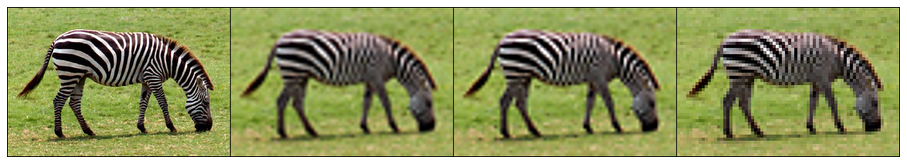

c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:9: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  if __name__ == '__main__':
c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.


PSNR bicubic: 18.5498   PSNR nearest: 17.6935


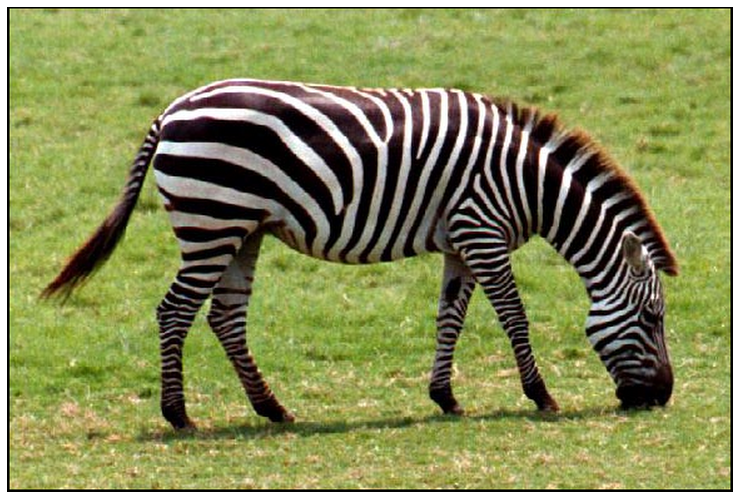

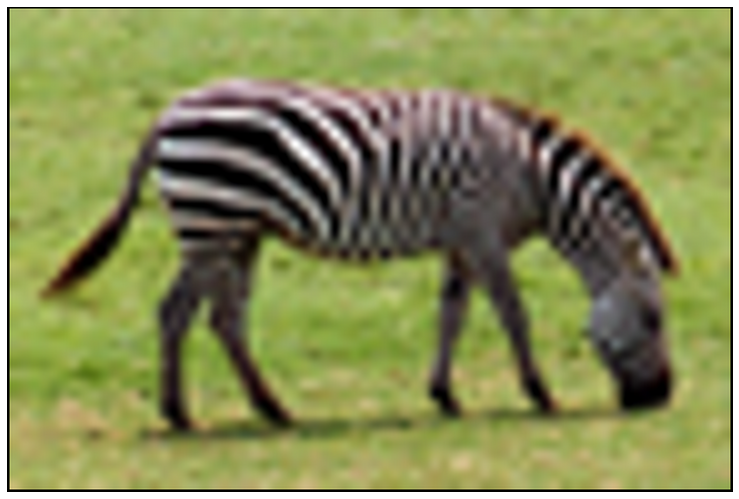

In [2]:
# Starts here
imgs = load_LR_HR_imgs_sr(path_to_image , imsize, factor, enforse_div32)

imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12);
    print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                        compare_psnr(imgs['HR_np'], imgs['bicubic_np']), 
                                        compare_psnr(imgs['HR_np'], imgs['nearest_np'])))
    plot_image_grid([imgs['HR_np']], 1,12);
    plot_image_grid([imgs['bicubic_np']], 1,12);

In [3]:
from skimage.transform import rescale, resize
def crop_rsz(image,bbox):
    sz1= image.shape[1]
    sz2= image.shape[2]
    print(image.shape)
    img_cropped = image[:,bbox[0]:bbox[2],bbox[1]:bbox[3]]
    img_cropped = resize(img_cropped.transpose(1,2,0), (sz1, sz2),anti_aliasing=True).transpose(2,0,1)
    return img_cropped


def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    duration = time.time() - startTime_for_tictoc
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(duration) + " seconds.")
    else:
        print("Toc: start time not set")
    return duration

# Set up parameters and net

In [4]:
input_depth = 32
 
INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4: 
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [5]:
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet
nchan=96
net = get_net(input_depth, 'skip', pad,
              skip_n33d=nchan, 
              skip_n33u=nchan, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

In [6]:
def closure():
    global i, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var) 
    
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)
        
    total_loss.backward()

    # Log
    psnr_LR = compare_psnr(imgs['LR_np'], torch_to_np(out_LR))
    psnr_HR = compare_psnr(imgs['HR_np'], torch_to_np(out_HR))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')
                      
    # History
    psnr_history.append([psnr_LR, psnr_HR])
    
    if PLOT and i % 200 == 0:
        out_HR_np = torch_to_np(out_HR)
        #plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)
        plot_image_grid([np.clip(out_HR_np, 0, 1)], factor=13, nrow=1)

    i += 1
    
    return total_loss

Starting optimization with ADAM


c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:18: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
c:\users\wnjq9\.conda\envs\siammask\lib\site-packages\ipykernel_launcher.py:19: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


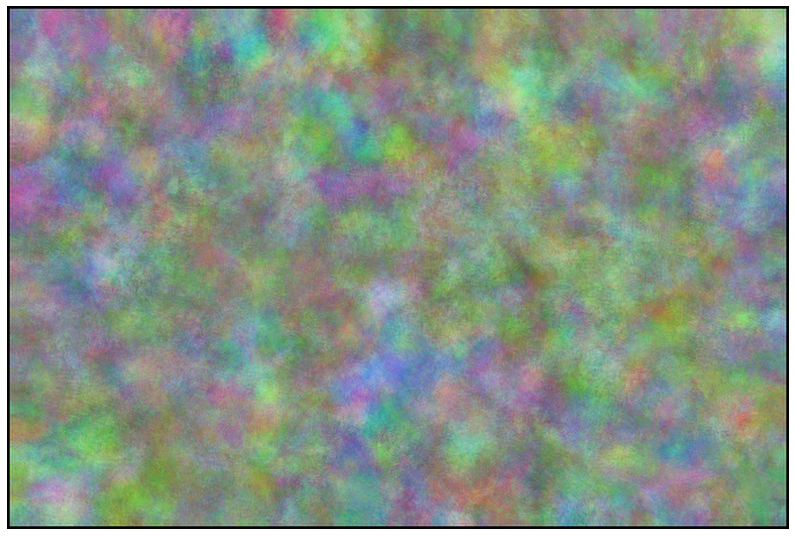

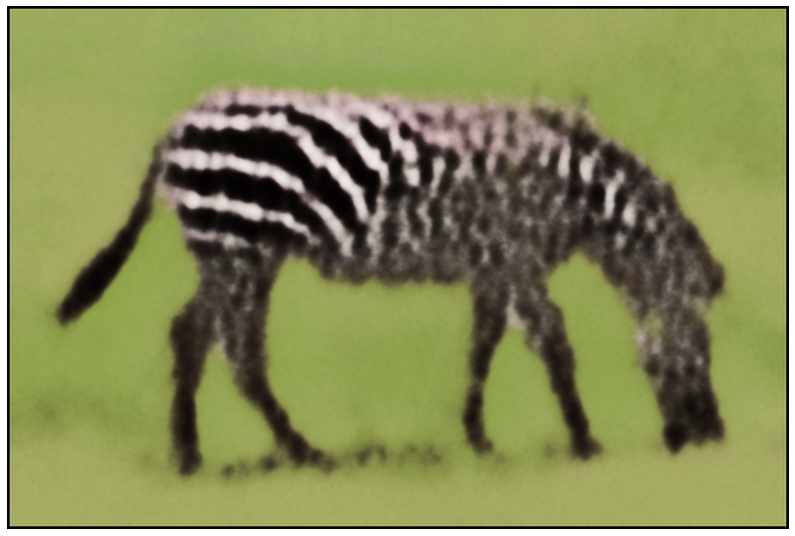

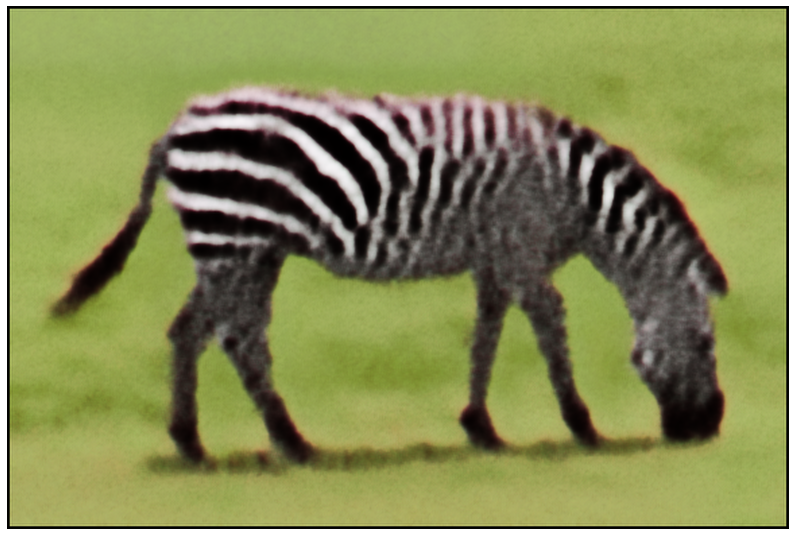

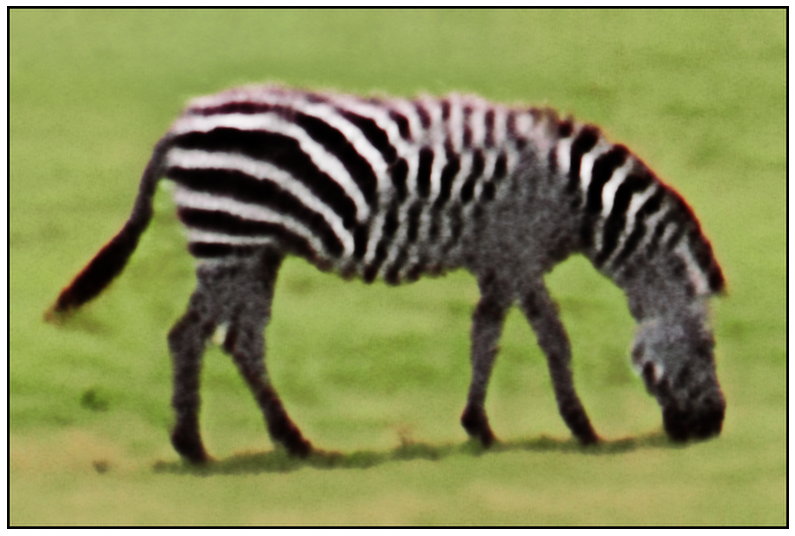

Elapsed time is 138.09098100662231 seconds. 18.915  
138.09098100662231


In [7]:
psnr_history = [] 
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
tic()
num_iter=800
optimize(OPTIMIZER, p, closure, LR, num_iter)
duration=toc()
duration_1stage=duration /num_iter
print(duration)

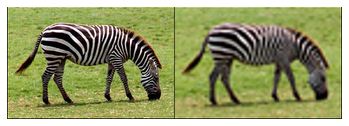

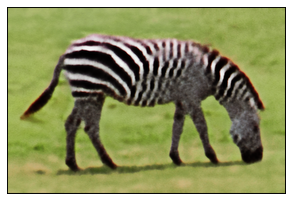

In [8]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)
result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np']], factor=4, nrow=2);
# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([out_HR_np], factor=4, nrow=1);

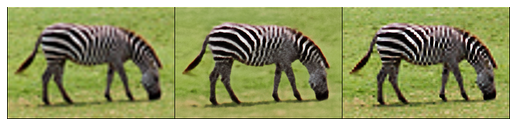

(3, 384, 576)
(3, 384, 576)
(3, 384, 576)
(3, 384, 576)


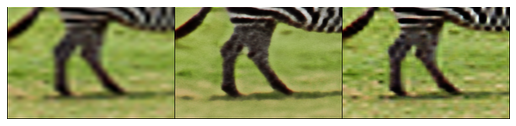

In [16]:
import pickle as pkl
# fname == 'data/denoising/snail.jpg'
# if fname == 'data/denoising/snail.jpg':
#     pklname_dip='data/denoising/denoising_snail_dip.pkl'
#     pklname_dnf='data/denoising/denoising_snail_dnf.pkl'
# else:
#     pklname='data/denoising/denoising_ft16_dip.pkl'
# pklname_dip='data/denoising/denoising_snail_dip.pkl'
pklname_dnf='data/sr/zebra_dnf.pkl'
out_np_dip=out_HR_np
[out_np_dnf, bicubic_np, hr_np]=pkl.load(open(pklname_dnf,'rb'))
# [out_np_dip, img_np2]=pkl.load(open(pklname_dip,'rb'))
bbox= [150,50,400,300]
plot_image_grid([bicubic_np,out_np_dip,out_np_dnf], factor=6)
out_np_dnf2=crop_rsz(out_np_dnf,bbox)
out_np_dip2=crop_rsz(out_np_dip,bbox)
bicubic_np2=crop_rsz(bicubic_np,bbox)
hr_np2=crop_rsz(hr_np,bbox)
plot_image_grid([bicubic_np2,out_np_dip2,out_np_dnf2], factor=6);
